# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import pprint
import json
from time import sleep
from datetime import date

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
# pip install citipy
from citipy import citipy

# Output File location
output_folder = "output_data"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# Think I can delete this:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
max_rows = 620 # Allows me to control # of API calls during testing to make it faster to iterate

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Create a dataframe and populate w the lat/lon
df = pd.DataFrame(lat_lngs, columns = ['Latitude', 'Longitude']) 

# Add the new columns you later need to get:
df["City"] = ""
df["Country"] = ""
df["Date"] = date.today()
df["Cloudiness"] = np.NaN
df["Humidity"] = np.NaN
df["Max Temp"] = np.NaN
df["Wind Speed"] = np.NaN

curr_rows = len(df)
print(f'There are {curr_rows} coordinates in the dataframe')

if curr_rows > max_rows:
    print(f"... that's more than the max of {max_rows} - culling to only be {max_rows}")
    df = df.head(max_rows)
    curr_rows = len(df)
    print(f'There are now {curr_rows} coordinates in the dataframe')
    
df.head()

There are 1500 coordinates in the dataframe
... that's more than the max of 620 - culling to only be 620
There are now 620 coordinates in the dataframe


,Latitude,Longitude,City,Country,Date,Cloudiness,Humidity,Max Temp,Wind Speed
0,22.233088,-49.676308,,,2020-01-23,NaN,NaN,NaN,NaN
1,-70.151047,26.986246,,,2020-01-23,NaN,NaN,NaN,NaN
2,-75.898007,5.550883,,,2020-01-23,NaN,NaN,NaN,NaN
3,-82.451657,-60.138620,,,2020-01-23,NaN,NaN,NaN,NaN
4,83.501309,-56.554683,,,2020-01-23,NaN,NaN,NaN,NaN


In [3]:
# Loop through the lat/lng and get the closest city (using citipy)
for index, row in df.iterrows():
    city = citipy.nearest_city(row["Latitude"], row["Longitude"])
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        #cities.append(city)
        df.loc[index, "City"] = city.city_name
        df.loc[index, "Country"] = city.country_code
        
df.head()

,Latitude,Longitude,City,Country,Date,Cloudiness,Humidity,Max Temp,Wind Speed
0,22.233088,-49.676308,codrington,ag,2020-01-23,NaN,NaN,NaN,NaN
1,-70.151047,26.986246,kruisfontein,za,2020-01-23,NaN,NaN,NaN,NaN
2,-75.898007,5.550883,hermanus,za,2020-01-23,NaN,NaN,NaN,NaN
3,-82.451657,-60.138620,ushuaia,ar,2020-01-23,NaN,NaN,NaN,NaN
4,83.501309,-56.554683,upernavik,gl,2020-01-23,NaN,NaN,NaN,NaN


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Save config information for https://openweathermap.org/current current weather:
base_url = "https://api.openweathermap.org/data/2.5/weather?"

# set up a parameters dictionary
params = {
    "appid": weather_api_key,
    "units": "imperial" # from api doc: "For temperature in Fahrenheit use units=imperial"
}

# base url
print('Beginning Data Retrieval')
print('----------------------------')

total_rows  = len(df)
total_rows_processed = 0
ctr = 0
batch = 1
rows_in_batch = 47
rows_processed_in_batch = 0

# Loop through datafram RBAR:
for index, row in df.iterrows():
    ctr += 1
    rows_processed_in_batch += 1
    total_rows_processed += 1
    
    # Sleep after every 47 calls:
    if rows_processed_in_batch >= rows_in_batch:
        batch += 1
        rows_processed_in_batch = 0
        print('')
        print('------------------------------')
        print(f'   {total_rows_processed} rows processed - {total_rows - total_rows_processed} remain')
        print('------------------------------')
        print('')
        sleep(1.01) # Time in seconds
           
    searchTerm = f'{row["City"]}, {row["Country"]}'
    params['q'] = searchTerm
    print(f'Processing record {ctr} of Set {batch} | {searchTerm}')
    
    # make request
    weather = requests.get(base_url, params=params)
    # print(weather.url)
    
    # convert to json
    weather_json = weather.json()
    #print(json.dumps(weather_json, indent=4))
    #break
    # Get the data
    
    # from docs: "For temperature in Fahrenheit use units=imperial"
    try:
        df.loc[index, "Cloudiness"] = f'{weather_json["clouds"]["all"]}'
        df.loc[index, "Humidity"] = f'{weather_json["main"]["humidity"]}'
        df.loc[index, "Max Temp"] = f'{weather_json["main"]["temp_max"]}'
        df.loc[index, "Wind Speed"] = f'{weather_json["wind"]["speed"]}'
    except:
        print("   error - one of the data points was not found for this city/country")

Beginning Data Retrieval
----------------------------
Processing record 1 of Set 1 | codrington, ag
   error - one of the data points was not found for this city/country
Processing record 2 of Set 1 | kruisfontein, za
Processing record 3 of Set 1 | hermanus, za
Processing record 4 of Set 1 | ushuaia, ar
Processing record 5 of Set 1 | upernavik, gl
Processing record 6 of Set 1 | belushya guba, ru
   error - one of the data points was not found for this city/country
Processing record 7 of Set 1 | rikitea, pf
Processing record 8 of Set 1 | taolanaro, mg
   error - one of the data points was not found for this city/country
Processing record 9 of Set 1 | rikitea, pf
Processing record 10 of Set 1 | mataura, pf
   error - one of the data points was not found for this city/country
Processing record 11 of Set 1 | rikitea, pf
Processing record 12 of Set 1 | chagda, ru
   error - one of the data points was not found for this city/country
Processing record 13 of Set 1 | itarema, br
Processing reco

Processing record 146 of Set 4 | shache, cn
Processing record 147 of Set 4 | punta arenas, cl
Processing record 148 of Set 4 | rikitea, pf
Processing record 149 of Set 4 | bluff, nz
Processing record 150 of Set 4 | pevek, ru
Processing record 151 of Set 4 | tuktoyaktuk, ca
Processing record 152 of Set 4 | georgetown, sh
Processing record 153 of Set 4 | kununurra, au
Processing record 154 of Set 4 | lagoa, pt
Processing record 155 of Set 4 | busselton, au
Processing record 156 of Set 4 | saldanha, za
Processing record 157 of Set 4 | mataura, pf
   error - one of the data points was not found for this city/country
Processing record 158 of Set 4 | esperance, au
Processing record 159 of Set 4 | faanui, pf
Processing record 160 of Set 4 | torbay, ca
Processing record 161 of Set 4 | petropavlovsk-kamchatskiy, ru
Processing record 162 of Set 4 | chivilcoy, ar
Processing record 163 of Set 4 | taltal, cl
Processing record 164 of Set 4 | albany, au
Processing record 165 of Set 4 | yellowknife, c

Processing record 288 of Set 7 | port alfred, za
Processing record 289 of Set 7 | yellowknife, ca
Processing record 290 of Set 7 | hilo, us
Processing record 291 of Set 7 | taolanaro, mg
   error - one of the data points was not found for this city/country
Processing record 292 of Set 7 | kapaa, us
Processing record 293 of Set 7 | severo-kurilsk, ru
Processing record 294 of Set 7 | chifeng, cn
Processing record 295 of Set 7 | hermanus, za
Processing record 296 of Set 7 | vaini, to
Processing record 297 of Set 7 | port alfred, za
Processing record 298 of Set 7 | longhua, cn
Processing record 299 of Set 7 | busselton, au
Processing record 300 of Set 7 | mayo, ca
Processing record 301 of Set 7 | rikitea, pf
Processing record 302 of Set 7 | vaini, to
Processing record 303 of Set 7 | busselton, au
Processing record 304 of Set 7 | kazalinsk, kz
   error - one of the data points was not found for this city/country
Processing record 305 of Set 7 | hobart, au
Processing record 306 of Set 7 | sa

Processing record 442 of Set 10 | rikitea, pf
Processing record 443 of Set 10 | glyadyanskoye, ru
Processing record 444 of Set 10 | ushuaia, ar
Processing record 445 of Set 10 | khomeyn, ir
Processing record 446 of Set 10 | kalambaka, gr
Processing record 447 of Set 10 | robe, et
Processing record 448 of Set 10 | lompoc, us
Processing record 449 of Set 10 | port hedland, au
Processing record 450 of Set 10 | maldonado, uy
Processing record 451 of Set 10 | cape town, za
Processing record 452 of Set 10 | hobart, au
Processing record 453 of Set 10 | hithadhoo, mv
Processing record 454 of Set 10 | yerbogachen, ru
Processing record 455 of Set 10 | atherton, au
Processing record 456 of Set 10 | dikson, ru
Processing record 457 of Set 10 | kaitangata, nz
Processing record 458 of Set 10 | bluff, nz
Processing record 459 of Set 10 | salalah, om
Processing record 460 of Set 10 | maningrida, au
Processing record 461 of Set 10 | longyearbyen, sj
Processing record 462 of Set 10 | norman wells, ca
Pr

Processing record 586 of Set 13 | megion, ru
Processing record 587 of Set 13 | nikolskoye, ru
Processing record 588 of Set 13 | vao, nc
Processing record 589 of Set 13 | ushuaia, ar
Processing record 590 of Set 13 | codrington, ag
   error - one of the data points was not found for this city/country
Processing record 591 of Set 13 | vestmannaeyjar, is
Processing record 592 of Set 13 | imbituba, br
Processing record 593 of Set 13 | hilo, us
Processing record 594 of Set 13 | torbay, ca
Processing record 595 of Set 13 | iqaluit, ca
Processing record 596 of Set 13 | san ramon de la nueva oran, ar
Processing record 597 of Set 13 | turtkul, uz
   error - one of the data points was not found for this city/country
Processing record 598 of Set 13 | bredasdorp, za
Processing record 599 of Set 13 | mys shmidta, ru
   error - one of the data points was not found for this city/country
Processing record 600 of Set 13 | guerrero negro, mx
Processing record 601 of Set 13 | lompoc, us
Processing record

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
#print(weather_json)
#print(weather.url)
#print(json.dumps(weather_json, indent=4, sort_keys=True))

curr_rows = len(df)
print(f'There are {curr_rows} coordinates in the dataframe')
print('... dropping rows that do not have weather data...')
df = df.dropna(how="any")
curr_rows = len(df)
print(f'After dropna(), there are now {curr_rows} coordinates in the dataframe')

df.to_csv (f'{output_folder}\RawData.csv', index = None, header=True) 
df.head()

There are 620 coordinates in the dataframe
... dropping rows that do not have weather data...
After dropna(), there are now 552 coordinates in the dataframe


,Latitude,Longitude,City,Country,Date,Cloudiness,Humidity,Max Temp,Wind Speed
1,-70.151047,26.986246,kruisfontein,za,2020-01-23,4,86,63.84,13.42
2,-75.898007,5.550883,hermanus,za,2020-01-23,0,80,70,11.99
3,-82.451657,-60.138620,ushuaia,ar,2020-01-23,75,71,50,24.16
4,83.501309,-56.554683,upernavik,gl,2020-01-23,44,59,-5.66,9.15
6,-29.975359,-129.818902,rikitea,pf,2020-01-23,0,77,79.5,16.91


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

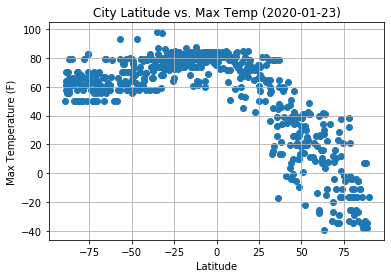

The relationship a city's latitude has with it's maximum temperature (F)
The skew towards the +20 and higher latitudes may be explained by lower hemisphere countries in Africa, Java, etc


In [57]:
## Convert to floats
x_values = df['Latitude'].astype('float')
y_values = df['Max Temp'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title(f'City Latitude vs. Max Temp ({date.today()})')
plt.grid()

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_max_temp.png')
plt.show()

print("The relationship a city's latitude has with it's maximum temperature (F)")
print('The skew towards the +20 and higher latitudes may be explained by lower hemisphere countries in Africa, Java, etc')

#### Latitude vs. Humidity Plot

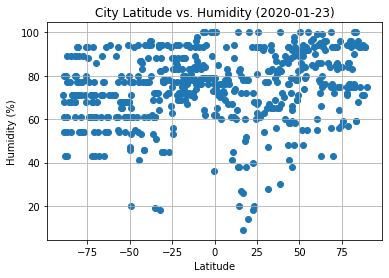

The relationship a city's latitude has with it's humidity
No clear and obvious relationships exist


In [58]:
## Convert to floats
x_values = df['Latitude'].astype('float')
y_values = df['Humidity'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title(f'City Latitude vs. Humidity ({date.today()})')
plt.grid()

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_humidity.png')
plt.show()

print("The relationship a city's latitude has with it's humidity")
print('No clear and obvious relationships exist')


#### Latitude vs. Cloudiness Plot

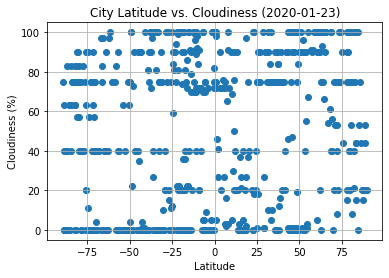

The relationship a city's latitude has with it's cloudiness
No clear and obvious relationships exist. Perhaps a measurement error but seems some clustering around 77% but no explanation as to why


In [59]:
## Convert to floats
x_values = df['Latitude'].astype('float')
y_values = df['Cloudiness'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f'City Latitude vs. Cloudiness ({date.today()})')
plt.grid()

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_clouds.png')
plt.show()

print("The relationship a city's latitude has with it's cloudiness")
print('No clear and obvious relationships exist. Perhaps a measurement error but seems some clustering around 77% but no explanation as to why')


#### Latitude vs. Wind Speed plot

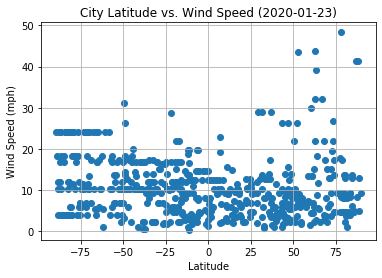

The relationship a city's latitude has with it's wind speed
Pretty flat - perhaps an outlier or two as well


In [60]:
## Convert to floats
x_values = df['Latitude'].astype('float')
y_values = df['Wind Speed'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f'City Latitude vs. Wind Speed ({date.today()})')
plt.grid()

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_wind.png')
plt.show()

print("The relationship a city's latitude has with it's wind speed")
print('Pretty flat - perhaps an outlier or two as well')

## Linear Regression

In [39]:
# OPTIONAL: Create a function to create Linear Regression plots

### BONUS 

def lin_line(x_values, y_values, plt, x_thing, y_thing):

    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    # Plot regression line
    plt.plot(
        x_values, 
        regress_values,
        "r-", 
        marker='o',
        markerfacecolor='blue',
        markeredgecolor='black'
    )
    
    plt.annotate(line_eq, (6,10), fontsize=15, color="red")

    # Print r square value
    print(f"R squared: {rvalue}")

    if rvalue <= -0.9:
        print(f'   - N.B. R-squared is <= -0.9 showing a definite relationship b/w {x_thing} and {y_thing}')
    elif rvalue <= -0.5:
        print(f'   - N.B. R-squared is <= -0.5 indicating there is a decent relationship b/w {x_thing} and {y_thing}')
    elif rvalue <= 0.2:
        print(f'   - N.B. R-squared is > -0.5 but < 0.2 indicating little to no definite relationship b/w {x_thing} and {y_thing}')
    elif rvalue >= 0.9:
        print(f'   - N.B. R-squared is >= 0.9 indicating there is a definite relationship b/w {x_thing} and {y_thing}')
    elif rvalue >= 0.5:
        print(f'   - N.B. R-squared is >= 0.5 indicating there is a decent relationship b/w {x_thing} and {y_thing}')
    else: 
        print(f'   - N.B. R-squared is >= 0.2 but < 0.5 indicating little to no definite relationship  b/w {x_thing} and {y_thing}')

In [40]:
# Create Northern and Southern Hemisphere DataFrames
the_union = df[(df["Latitude"] >= 0)]
the_confederates = df[(df["Latitude"] < 0)]

print(f'There are {len(the_union)} rows in the Northern hemisphere')
print(f'Ya\'ll, there are {len(the_confederates)} rows in the Southern, I said Southern, hemisphere')

There are 254 rows in the Northern hemisphere
Ya'll, there are 298 rows in the Southern, I said Southern, hemisphere


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

R squared: -0.8688344932261053
   - N.B. R-squared is <= -0.5 indicating there is a decent relationship b/w Latitude and Max Temp(F)


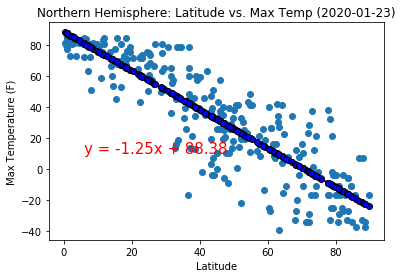

The relationship a city's latitude has with it's maximum temperature (F)


In [49]:
# Convert to floats
x_values = the_union['Latitude'].astype('float')
y_values = the_union['Max Temp'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title(f'Northern Hemisphere: Latitude vs. Max Temp ({date.today()})')

lin_line(x_values, y_values, plt, 'Latitude', 'Max Temp(F)')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_max_temp-linear-north.png')
plt.show()

print("The relationship a city's latitude has with it's maximum temperature (F)")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

R squared: 0.6531697172047972
   - N.B. R-squared is >= 0.5 indicating there is a decent relationship b/w Latitude and Max Temp(F)


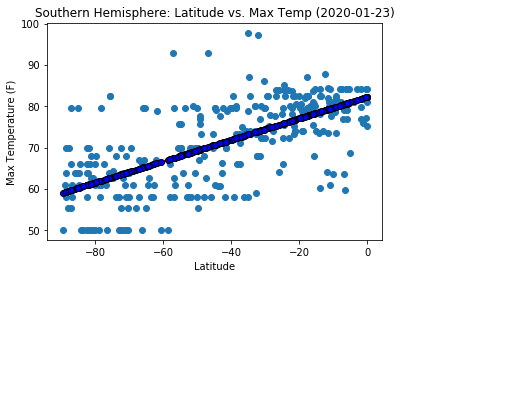

The relationship a city's latitude has with it's maximum temperature (F)


In [50]:
# Convert to floats
x_values = the_confederates['Latitude'].astype('float')
y_values = the_confederates['Max Temp'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title(f'Southern Hemisphere: Latitude vs. Max Temp ({date.today()})')

lin_line(x_values, y_values, plt, 'Latitude', 'Max Temp(F)')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_max_temp-linear-south.png')
plt.show()

print("The relationship a city's latitude has with it's maximum temperature (F)")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

R squared: 0.28252790207308104
   - N.B. R-squared is >= 0.2 but < 0.5 indicating little to no definite relationship  b/w Latitude and Humidity


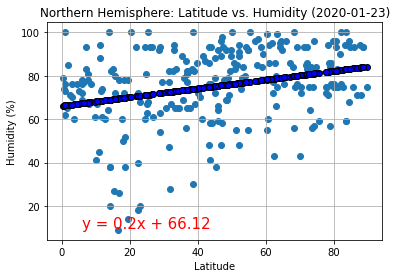

The relationship a city's latitude has with it's humidity(%)


In [51]:
## Convert to floats
x_values = the_union['Latitude'].astype('float')
y_values = the_union['Humidity'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title(f'Northern Hemisphere: Latitude vs. Humidity ({date.today()})')
plt.grid()

lin_line(x_values, y_values, plt, 'Latitude', 'Humidity')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_humid-linear-north.png')
plt.show()

print("The relationship a city's latitude has with it's humidity(%)")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

R squared: 0.2711666556119306
   - N.B. R-squared is >= 0.2 but < 0.5 indicating little to no definite relationship  b/w Latitude and Humidity


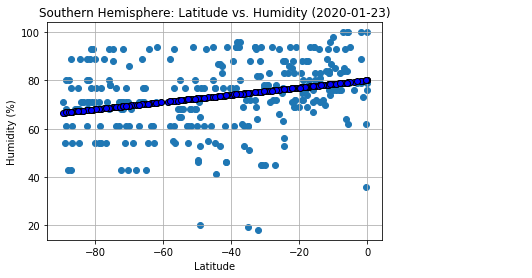

The relationship a city's latitude has with it's humidity(%)


In [52]:
## Convert to floats
x_values = the_confederates['Latitude'].astype('float')
y_values = the_confederates['Humidity'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title(f'Southern Hemisphere: Latitude vs. Humidity ({date.today()})')
plt.grid()

lin_line(x_values, y_values, plt, 'Latitude', 'Humidity')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_humid-linear-south.png')
plt.show()

print("The relationship a city's latitude has with it's humidity(%)")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

R squared: 0.15163265571380147
   - N.B. R-squared is > -0.5 but < 0.2 indicating little to no definite relationship b/w Latitude and Cloudiness


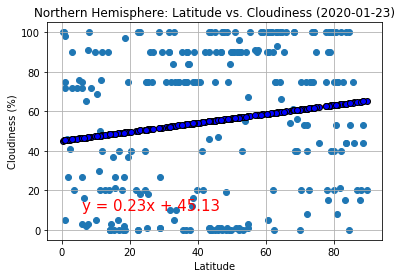

The relationship a city's latitude has with it's cloudiness(%)


In [53]:
## Convert to floats
x_values = the_union['Latitude'].astype('float')
y_values = the_union['Cloudiness'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f'Northern Hemisphere: Latitude vs. Cloudiness ({date.today()})')
plt.grid()
lin_line(x_values, y_values, plt, 'Latitude', 'Cloudiness')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_cloud-linear-north.png')
plt.show()

print("The relationship a city's latitude has with it's cloudiness(%)")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

R squared: 0.10758410050984284
   - N.B. R-squared is > -0.5 but < 0.2 indicating little to no definite relationship b/w Latitude and Cloudiness


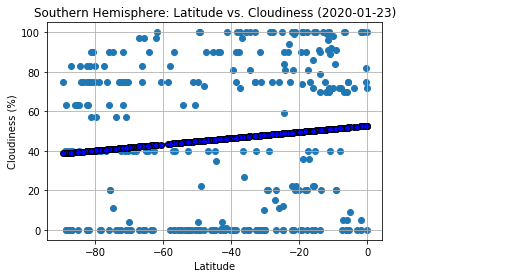

The relationship a city's latitude has with it's cloudiness(%)


In [54]:
## Convert to floats
x_values = the_confederates['Latitude'].astype('float')
y_values = the_confederates['Cloudiness'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title(f'Southern Hemisphere: Latitude vs. Cloudiness ({date.today()})')
plt.grid()

lin_line(x_values, y_values, plt, 'Latitude', 'Cloudiness')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_cloud-linear-south.png')
plt.show()

print("The relationship a city's latitude has with it's cloudiness(%)")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

R squared: 0.17316481001208175
   - N.B. R-squared is > -0.5 but < 0.2 indicating little to no definite relationship b/w Latitude and Wind Speed


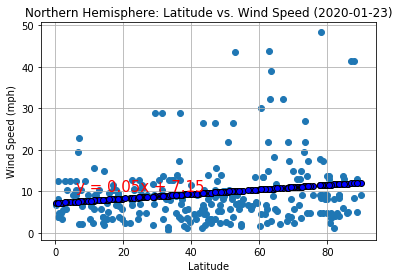

The relationship a city's latitude has with it's wind speed


In [55]:
## Convert to floats
x_values = the_union['Latitude'].astype('float')
y_values = the_union['Wind Speed'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f'Northern Hemisphere: Latitude vs. Wind Speed ({date.today()})')
plt.grid()
lin_line(x_values, y_values, plt, 'Latitude', 'Wind Speed')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_wind-linear-north.png')
plt.show()

print("The relationship a city's latitude has with it's wind speed")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

R squared: -0.25102010816133297
   - N.B. R-squared is > -0.5 but < 0.2 indicating little to no definite relationship b/w Latitude and Wind Speed


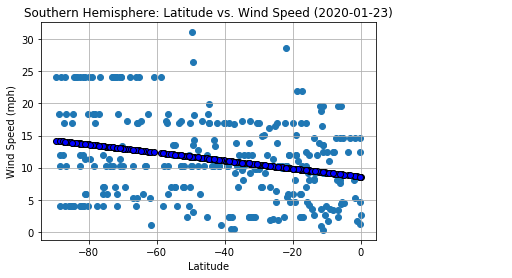

The relationship a city's latitude has with it's wind speed


In [56]:
## Convert to floats
x_values = the_confederates['Latitude'].astype('float')
y_values = the_confederates['Wind Speed'].astype('float')

# Plot scatter plot
plt.scatter(x_values, y_values)

# Label plot
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title(f'Southern Hemisphere: Latitude vs. Wind Speed ({date.today()})')
plt.grid()
lin_line(x_values, y_values, plt, 'Latitude', 'Wind Speed')

# Show plot
plt.savefig(f'{output_folder}\plot_lat_vs_wind-linear-south.png')
plt.show()

print("The relationship a city's latitude has with it's wind speed")